In [1]:
from sstadex import Macromodel, Primitive, Test, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim, diffpair_cc
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify

from sstadex import Transistor
import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

# LDO exploration with IHP130: Cascode differential pair and simple active load

In [2]:
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.8                                      # LDO output voltage
Vin = 3.3                                       # LDO supply voltage
Vref = 1.35                                     # LDO voltage reference
IL = 100e-3                                     # Load current
CL = 1e-12                                      # Load capacitance
RL = Vout/IL

## LDO specifications
    
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3

I_amp =20e-6

## Preparation

### Macromodels

In [3]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 2.5, 5)  # this will be used in the near future

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_diff_m1"), Symbol("L_diff_m1"), Symbol("W_diff_m2"), Symbol("L_diff_m2"), Symbol("W_al"), Symbol("L_al"), Symbol("W_pt"), Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.7,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = [10e-3, 0]

## OTA CASCODE DIFFPAIR MACROMODEL

OTA_ccdiff = Macromodel(name = "ota_ccdiff",
                       outputs = [Symbol("W_diff_m1"), 
                                  Symbol("L_diff_m1"), 
                                  Symbol("W_diff_m2"), 
                                  Symbol("L_diff_m2"), 
                                  Symbol("W_aload"), 
                                  Symbol("L_aload")],
                       req_tfs = [["vout", "vpos"], 
                                  ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={"Vdd": LDO_macro.electrical_parameters["Vdd"],
                                              "Vref": LDO_macro.electrical_parameters["Vref"],
                                              "Vout": LDO_macro.electrical_parameters["Vaout"],
                                              "I": I_amp}
                      )

OTA_ccdiff.area_conditions = [10e-3, 1, 1, 1]

### Primitives

In [4]:
## PASS TRANSISTOR PRIMITIVE ###############################################################

pt = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-2, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': LDO_macro.electrical_parameters["Il"],
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt.Ro).flatten(),
                 Symbol("Cgs_pt"): np.asarray(pt.cgg).flatten()+np.asarray(pt.cgd).flatten()*np.asarray(pt.gm).flatten()*np.asarray(pt.Ro).flatten(),
                 Symbol("Cgd"): np.asarray(pt.cgd).flatten()}
pt.outputs = {Symbol("W_pt"): np.asarray(pt.W).flatten(),
              Symbol("L_pt"): np.asarray(pt.L).flatten()}

## DIFF PAIR PRIMITIVE #####################################################################

sweep_size = 2
vin = OTA_ccdiff.electrical_parameters["Vref"]
vout = OTA_ccdiff.electrical_parameters["Vout"]
vs = np.linspace(0.1, vin-0.1, sweep_size)
vcp = np.linspace(vin, vout-0.1, sweep_size)

diffpair_primitive = diffpair_cc(vcp, vs, vin, vout, I_amp, sweep_size, lengths)
diffpair_primitive.build()      

diffpair_primitive.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive.gm).flatten(),
                                 Symbol("Cgd"): np.asarray(diffpair_primitive.cgd_m1).flatten(),
                                 Symbol("Cgs"): np.asarray(diffpair_primitive.cgs_m1).flatten(),
                                 Symbol("vbias"): np.asarray(diffpair_primitive.vbias).flatten(), ########################
                                 Symbol("Rdif_m1_1"): np.asarray(diffpair_primitive.Ro_m1).flatten(), 
                                 Symbol("gdif_m1_1"): np.asarray(diffpair_primitive.gm_m1).flatten(),
                                 Symbol("Rdif_m2_1"): np.asarray(diffpair_primitive.Ro_m2).flatten(), 
                                 Symbol("gdif_m2_1"): np.asarray(diffpair_primitive.gm_m2).flatten(),
                                 Symbol("Cds_m1"): np.asarray(np.abs(diffpair_primitive.cds_m1)).flatten(),
                                 Symbol("Cgs_m2"): np.asarray(np.abs(diffpair_primitive.cgs_m2)).flatten(),
                                 Symbol("Cgd_m2"): np.asarray(np.abs(diffpair_primitive.cgd_m2)).flatten()}
diffpair_primitive.outputs = {Symbol("W_diff_m1"): np.asarray(diffpair_primitive.W_m1).flatten(),
                              Symbol("W_diff_m2"): np.asarray(diffpair_primitive.W_m2).flatten(),
                              Symbol("L_diff_m1"): np.asarray(diffpair_primitive.L_m1).flatten(),
                              Symbol("L_diff_m2"): np.asarray(diffpair_primitive.L_m2).flatten()}

## OTA stage1 active load ################################################################

ota_cm_pmos = cm_pmos(name='ota_cm_pmos', 
                      netlist='pmos_cm ', 
                      type='pmos', 
                      inputs={'vds_lut': OTA_ccdiff.electrical_parameters["Vout"]-OTA_ccdiff.electrical_parameters["Vdd"], 
                              'vgs_lut': (-2, -0.1, 0.01), 
                              'vgs': OTA_ccdiff.electrical_parameters["Vout"]-OTA_ccdiff.electrical_parameters["Vdd"], 
                              'il': OTA_ccdiff.electrical_parameters["I"],
                              'length': lengths, 
                              '2d_var': ['length', 'vgs']})
ota_cm_pmos.build()

ota_cm_pmos.parameters = {Symbol("Raload_1"): np.asarray(ota_cm_pmos.Ro).flatten(),
                          Symbol("gaload"): np.asarray(ota_cm_pmos.gm).flatten()}
ota_cm_pmos.outputs = {Symbol("W_aload"): np.asarray(ota_cm_pmos.W).flatten(),
                       Symbol("L_aload"): np.asarray(ota_cm_pmos.L).flatten()}

length
vgs
0
vds
vgs
1
M1 jd:  [[7.25617454e+01 6.08249885e-07 7.42184014e+01 7.41052912e-07]
 [2.68475066e+01 5.76879734e-08 2.71720535e+01 6.32482759e-08]
 [1.33920261e+01 9.84013468e-08 1.34668188e+01 1.02400065e-07]
 [6.77136134e+00 1.00439538e-07 6.79065407e+00 1.02550571e-07]
 [3.40715906e+00 7.25296697e-08 3.41217923e+00 7.35222146e-08]]
M1 gmid:  [[ 2.69279641 25.30420007  2.66803299 25.40744333]
 [ 3.30401794 27.22257732  3.29890682 27.22820591]
 [ 3.25801581 27.01886508  3.25388912 27.0370461 ]
 [ 3.19952501 26.94207611  3.1973779  26.96199379]
 [ 3.16791814 26.89798144  3.16686343 26.90787924]]
vds
vgs
1
M2 jd:  [[        nan 10.16071181         nan 10.16071181         nan  0.32918475
          nan  0.32918475         nan 10.16071181         nan 10.16071181
          nan  0.32918475         nan  0.32918475         nan 10.16071181
          nan 10.16071181         nan  0.32918475         nan  0.32918475
          nan 10.16071181         nan 10.16071181         nan  0.32918475

### Testbenches

In [5]:
#################### PSRR LDO MACRO #######################
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo_psrr"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Rl"): RL,
                             Symbol("Cl"): CL,
                             Symbol("Cc"): 1e-12,
                             Symbol("R1"): 100000, 
                             Symbol("R2"): 300000}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(-70/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

#################### BW LDO MACRO #######################
bw_LDO_macro = Test()
bw_LDO_macro.name = "bw_LDO"
bw_LDO_macro.tf = ["vout", "vdd"]
bw_LDO_macro.netlist = "ldo"
bw_LDO_macro.parametros = {Symbol("V1"): 1,
                           Symbol("V2"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("Cc"): 1e-12,
                           Symbol("R1"): 100000,
                           Symbol("R2"): 300000}

bw_LDO_macro.conditions = {"min": [1e4]}
bw_LDO_macro.variables = {}
bw_LDO_macro.out_def = {"frec": [bw_LDO_macro.tf, -0.70794]}

#################### load regulation LDO MACRO #######################
loadreg_LDO_macro = Test()
loadreg_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
loadreg_LDO_macro.parametros = {Symbol("V1"): 1.8,
                                Symbol("V2"): 1.35,
                                Symbol("s"): 0,
                                Symbol("Cl"): CL,
                                Symbol("Cc"): 1e-12,
                                Symbol("R1"): 100000,
                                Symbol("R2"): 300000}

loadreg_LDO_macro.variables = {Symbol('Rl'): [RL, RL+1200]}
loadreg_LDO_macro.out_def = {'diff': [loadreg_LDO_macro.tf, loadreg_LDO_macro.variables]}
loadreg_LDO_macro.conditions = {'max': [1]}

##################### OPENLOOP ######################################

ol_gain_LDO_macro = Test()
ol_gain_LDO_macro.name = "ol_gain_LDO"
ol_gain_LDO_macro.tf = ["vout", "vol"]
ol_gain_LDO_macro.netlist = "ldo_ol"
ol_gain_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("s"): 0,
                             Symbol("Rl"): RL,
                             Symbol("Cl"): CL,
                             Symbol("R1"): 100000, 
                             Symbol("R2"): 300000,
                             Symbol("R4"): 100000000,
                             Symbol("C2"): 10}

ol_gain_LDO_macro.opt_goal = "min"
ol_gain_LDO_macro.conditions = {"min": [1]}
ol_gain_LDO_macro.variables = {}
ol_gain_LDO_macro.out_def = {"eval": ol_gain_LDO_macro.tf}

##################### OPENLOOP ######################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("Rl"): RL,
                             Symbol("Cl"): CL,
                             Symbol("R1"): 100000, 
                             Symbol("R2"): 300000,
                             Symbol("R4"): 100000000,
                             Symbol("C2"): 10}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [1]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

###############################################################################################################################

#################### PSRR 1stage OTa #######################
psrr_1stage_OTA = Test()
psrr_1stage_OTA.tf = ("vout", "vpos")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_cap"
psrr_1stage_OTA.parametros = {Symbol("gaload_2"): Symbol("gaload"),
                              Symbol("Raload_2"): Symbol("Raload_1"),
                              Symbol("gdif_2"): Symbol("gdif_1"), 
                              Symbol("Rdif_2"): Symbol("Rdif_1"),
                              Symbol("V1"): 0,
                              Symbol("V_b"): 0,
                              Symbol("V_n"): 0,
                              Symbol("V_p"): 1,
                              Symbol("I2"): 0,
                              Symbol("s"): 0,
                              Symbol("Cl"): 1e-12}

psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [0]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

#################### BW 1stage OTA #######################

bw_1stage_OTA = Test()
bw_1stage_OTA.tf = ("vout", "vpos")
bw_1stage_OTA.name = "bw_1stage"
bw_1stage_OTA.netlist = "ota_cap_cc"
bw_1stage_OTA.parametros = {Symbol("gdif_m1_2"): Symbol("gdif_m1_1"),
                              Symbol("gdif_m2_2"): Symbol("gdif_m2_1"),
                                Symbol("Rdif_m1_2"): Symbol("Rdif_m1_1"),
                                Symbol("Rdif_m2_2"): Symbol("Rdif_m2_1"),
                                Symbol("gaload_2"): Symbol("gaload"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("gdif_2"): Symbol("gdif_1"),
                                Symbol("Rdif_2"): Symbol("Rdif_1"),
                                Symbol("V1"): 0,
                                Symbol("V_b"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 1,
                                Symbol("I2"): 0,
                                Symbol("Cl"): 1e-12}

bw_1stage_OTA.conditions = {"min": [1e2]}
bw_1stage_OTA.variables = {}
bw_1stage_OTA.out_def = {"frec": [bw_1stage_OTA.tf, -0.70794]}

#################### rout 1 stage OTA #######################
rout_1stage_OTA = Test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_cap_r"
rout_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                              Symbol("Rdif_2"): Symbol("Rdif_1"),
                                Symbol("gaload_2"): Symbol("gaload"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1.291550e+01]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

#################### gm 1 stage OTA #######################

gm_1stage_OTA = Test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_cap"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [psrr_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"
gm_1stage_OTA.conditions = {"min": [0.00001]}

## Build OTA

### Exploration

In [6]:
OTA_ccdiff.primitives = [diffpair_primitive, ota_cm_pmos]
OTA_ccdiff.submacromodels = []
OTA_ccdiff.num_level_exp = 1
OTA_ccdiff.specifications = [psrr_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA, bw_1stage_OTA]
OTA_ccdiff.opt_specifications = [psrr_1stage_OTA]
OTA_ccdiff.is_primitive = 0

ota1_results, ota1_axes, ota1_primouts, ota1_df = dfs(OTA_ccdiff, debug = False)

############################################
Starting the exploration of:  ota_ccdiff
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[('vout', 'vpos')]
Netlist:  ota_cap_r
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd  vr
0     1   2     3     4     5    0    6   7
[['vout', 'vr']]
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[['vout', 'vpos']]
Netlist:  ota_cap_cc
Running MNA... 
   net1  vs  vss  vcp  vpos  vout  net2
0     1   2    0    3     4     5     6
[('vout', 'vpos')]
{<sstadex.models.primitives.diffpair_cc object at 0x7fe7aeee37f0>: {Rdif_1: array([           nan, 9.06831238e+06,            nan, 5.31807211e+05,
                  nan, 6.07585357e+06,            nan, 8.02965719e+05,
                  nan, 1.64979896e+07,            nan, 7.85216168e+05,
                  nan, 1.17440626e+07,            nan, 2.18688484e+06,
           

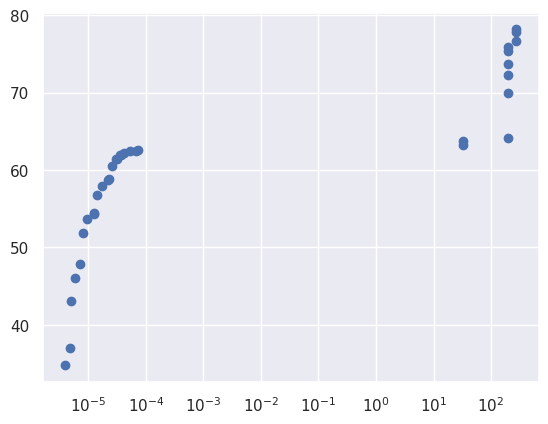

In [7]:
ota1_df["gain"]=20*np.log10(ota1_df["psrr_1stage"])

area = ota1_df["area"]
gain = ota1_df["gain"]

plt.scatter(area, gain)
plt.xscale("log")

In [10]:
ota1_df

,Rdif_1,gdif_1,Cgd,Cgs,vbias,Rdif_m1_1,gdif_m1_1,Rdif_m2_1,gdif_m2_1,Cds_m1,...,gm_1stage,bw_1stage,W_diff_m1,L_diff_m1,W_diff_m2,L_diff_m2,W_aload,L_aload,area,gain
218,2.287139e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,181686.410842,0.000165,5.324166e-14,...,0.000063,3872038.781813,0.000006,0.000006,0.000006,8.000000e-07,0.000011,0.000006,0.000037,61.977753
228,3.619304e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,319245.265198,0.000148,5.324166e-14,...,0.000063,3872038.781813,0.000006,0.000006,0.000011,1.600000e-06,0.000011,0.000006,0.000042,62.259464
238,5.605043e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,525118.701014,0.000139,5.324166e-14,...,0.000063,2673841.61584,0.000006,0.000006,0.000020,3.200000e-06,0.000011,0.000006,0.000052,62.435392
248,8.814468e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,850441.682557,0.000135,5.324166e-14,...,0.000063,1275051.240713,0.000006,0.000006,0.000037,6.400000e-06,0.000011,0.000006,0.000073,62.554143


In [11]:
ota1_df = ota1_df[(ota1_df[Symbol("W_diff_m1")]>5e-6) & (ota1_df[Symbol("W_diff_m2")]>5e-6) & (ota1_df[Symbol("W_aload")]>5e-6)].sort_values(by="area")
ota1_df

,Rdif_1,gdif_1,Cgd,Cgs,vbias,Rdif_m1_1,gdif_m1_1,Rdif_m2_1,gdif_m2_1,Cds_m1,...,gm_1stage,bw_1stage,W_diff_m1,L_diff_m1,W_diff_m2,L_diff_m2,W_aload,L_aload,area,gain
218,2.287139e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,181686.410842,0.000165,5.324166e-14,...,0.000063,3872038.781813,0.000006,0.000006,0.000006,8.000000e-07,0.000011,0.000006,0.000037,61.977753
228,3.619304e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,319245.265198,0.000148,5.324166e-14,...,0.000063,3872038.781813,0.000006,0.000006,0.000011,1.600000e-06,0.000011,0.000006,0.000042,62.259464
238,5.605043e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,525118.701014,0.000139,5.324166e-14,...,0.000063,2673841.61584,0.000006,0.000006,0.000020,3.200000e-06,0.000011,0.000006,0.000052,62.435392
248,8.814468e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,850441.682557,0.000135,5.324166e-14,...,0.000063,1275051.240713,0.000006,0.000006,0.000037,6.400000e-06,0.000011,0.000006,0.000073,62.554143


### Comparation

In [12]:
W_diff_m1 = ota1_df[Symbol("W_diff_m1")].values*1e6
L_diff_m1 = ota1_df[Symbol("L_diff_m1")].values*1e6

W_diff_m2 = ota1_df[Symbol("W_diff_m2")].values*1e6
L_diff_m2 = ota1_df[Symbol("L_diff_m2")].values*1e6

W_al_pf = (ota1_df[Symbol("W_aload")].values*1e6)
L_al_pf = (ota1_df[Symbol("L_aload")].values*1e6)

#W_s2_pf = (final_dict[Symbol("W_2stage")].values*1e6)
#L_s2_pf = (final_dict[Symbol("L_2stage")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff_m1):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_pf):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM6": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "I2": np.full(len(W_diff_m1), I_amp*2),
    "Vbias": ota1_df[Symbol("vbias")].values
}

simulation_results = spice_sim("ota_tb_ihp_cc", values)

[array([5.86999305, 5.86999305, 5.86999305, 5.86999305]), array([6.4, 6.4, 6.4, 6.4]), [1, 1, 1, 1], 'nfet']
test numer:  0
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/sstadex/xschem/ota_tb_ihp_cc.sch

**.subckt ota_tb_ihp_cc

['I2', 'vs', 'vss', '4e-05']
I2 vs vss 4e-05 

XM1
['XM1', 'vcp', 'vp1', 'vs', 'vs', 'sg13_hv_nmos', 'L=6.3999999999999995u', 'W=5.869993046820324u', 'ng=1', 'm=1']
XM1 vcp vp1 vs vs sg13_hv_nmos L=6.3999999999999995u W=5.869993046820324u ng=1 m=1 

XM2
['XM2', 'net2', 'vn', 'vs', 'vs', 'sg13_hv_nmos', 'L=6.3999999999999995u', 'W=5.869993046820324u', 'ng=1', 'm=1']
XM2 net2 vn vs vs sg13_hv_nmos L=6.3999999999999995u W=5.869993046820324u ng=1 m=1 

XM3
['XM3', 'vout', 'vbias', 'vcp', 'vcp', 'sg13_hv_nmos', 'L=0.7999999999999999u', 'W=6.417839102984971u', 'ng=1', 'm=1']
XM3 vout vbias vcp vcp sg13_hv_nmos L=0.7999999999999999u W=6.417839102984971u ng=1 m=1 

XM4
['XM4', 'net1', 'vbias', 'net2', 'net2', 'sg13_hv_nmos', 'L=0.7999999999999999u

In [13]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ota1_df["gain_sim"]=gain_error
ota1_df["gain_error"] = (np.abs(np.asarray(gain_error) - ota1_df["gain"].values)/np.asarray(gain_error))*100

In [15]:
ota1_df

,Rdif_1,gdif_1,Cgd,Cgs,vbias,Rdif_m1_1,gdif_m1_1,Rdif_m2_1,gdif_m2_1,Cds_m1,...,W_diff_m1,L_diff_m1,W_diff_m2,L_diff_m2,W_aload,L_aload,area,gain,gain_sim,gain_error
218,2.287139e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,181686.410842,0.000165,5.324166e-14,...,0.000006,0.000006,0.000006,8.000000e-07,0.000011,0.000006,0.000037,61.977753,61.835751,0.229644
228,3.619304e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,319245.265198,0.000148,5.324166e-14,...,0.000006,0.000006,0.000011,1.600000e-06,0.000011,0.000006,0.000042,62.259464,62.133435,0.202836
238,5.605043e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,525118.701014,0.000139,5.324166e-14,...,0.000006,0.000006,0.000020,3.200000e-06,0.000011,0.000006,0.000052,62.435392,62.317678,0.188893
248,8.814468e+08,0.000063,-2.465226e-17,1.036335e-13,2.2,7.652436e+06,0.000063,850441.682557,0.000135,5.324166e-14,...,0.000006,0.000006,0.000037,6.400000e-06,0.000011,0.000006,0.000073,62.554143,62.440745,0.181609


## Build LDO

In [44]:
W_diff_m1 = ota1_df[Symbol("W_diff_m1")].values
L_diff_m1 = ota1_df[Symbol("L_diff_m1")].values

W_diff_m2 = ota1_df[Symbol("W_diff_m2")].values
L_diff_m2 = ota1_df[Symbol("L_diff_m2")].values

W_al = (ota1_df[Symbol("W_aload")].values)
L_al = (ota1_df[Symbol("L_aload")].values)

gm_OTA_ccdiff = ota1_df["gm_1stage"].values
Ro_OTA_ccdiff = ota1_df["rout_1stage"].values

In [45]:
OTA_primitive = Primitive(parameters={Symbol("Ra"): Ro_OTA_ccdiff,
                                  Symbol("gma"): gm_OTA_ccdiff,
                                  Symbol('Ca'): 1/(ota1_df["bw_1stage"].values.astype(float)*2*np.pi*Ro_OTA_ccdiff),
                                  Symbol("vbias"): ota1_df[Symbol("vbias")]})
OTA_primitive.outputs = {Symbol("W_diff_m1"): W_diff_m1,
                         Symbol("L_diff_m1"): L_diff_m1,
                         Symbol("W_diff_m2"): W_diff_m2,
                         Symbol("L_diff_m2"): L_diff_m2,
                         Symbol("W_al"): W_al,
                         Symbol("L_al"): L_al}

In [46]:
LDO_macro.primitives=[OTA_primitive, pt]
LDO_macro.submacromodels=[]
LDO_macro.num_level_exp=1
LDO_macro.specifications=[psrr_LDO_macro, ol_gain_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications=[psrr_LDO_macro]
LDO_macro.is_primitive=0

ldo_results, ldo_axes, ldo_primouts, ldo_df = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_ol
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  vpos
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  vpos
0    0     1     2    3    4     5
[['vout', 'vol']]
{<sstadex.models.primitives.Primitive object at 0x7f0238b5cd90>: {Ra: array([19831178.092766  , 20484511.96343231, 20903396.88828707,
       21190979.69164521]), gma: array([6.33197409e-05, 6.33209727e-05, 6.33217220e-05, 6.33222192e-05]), Ca: array([2.07267839e-15, 2.00657230e-15, 2.84752527e-15, 5.89035484e-15]), vbias: 218    2.2
228    2.2
238    2.2
248    2.2
Name: vbias, dtype: float64}, <sstadex.models.primitives.cs_pmos object at 0x7f0238d94b50>: {gm_pt: array([0.1858436 , 0.19762954, 0.20270411, 0.20526317, 0.20656096]), Ro_pt: array([ 202.03

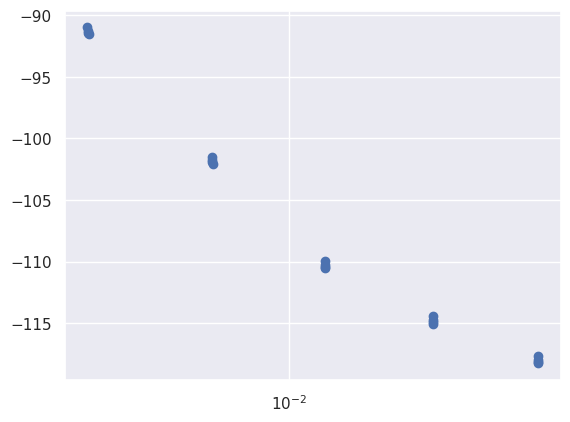

In [47]:
ldo_df["gain"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["ol_gain"] = 20*np.log10(ldo_df["ol_gain_LDO"])

area = ldo_df["area"]
psrr = ldo_df["gain"]

plt.scatter(area, psrr)
plt.xscale("log")

In [48]:
ldo_df

,Ra,gma,Ca,vbias,gm_pt,Ro_pt,Cgs_pt,Cgd,psrr_LDO,ol_gain_LDO,...,L_diff_m1,W_diff_m2,L_diff_m2,W_al,L_al,W_pt,L_pt,area,gain,ol_gain
0,1.983118e+07,0.000063,2.072678e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000028,3856.776733,...,0.000006,0.000006,8.000000e-07,0.000011,0.000006,0.002488,4.000000e-07,0.002525,-90.973423,71.724490
1,2.048451e+07,0.000063,2.006572e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000027,3983.914909,...,0.000006,0.000011,1.600000e-06,0.000011,0.000006,0.002488,4.000000e-07,0.002530,-91.255038,72.006201
2,2.090340e+07,0.000063,2.847525e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000027,4065.429533,...,0.000006,0.000020,3.200000e-06,0.000011,0.000006,0.002488,4.000000e-07,0.002540,-91.430908,72.182129
3,2.119098e+07,0.000063,5.890355e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000026,4121.392885,...,0.000006,0.000037,6.400000e-06,0.000011,0.000006,0.002488,4.000000e-07,0.002561,-91.549621,72.300880
4,1.983118e+07,0.000063,2.072678e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4344.147082,...,0.000006,0.000006,8.000000e-07,0.000011,0.000006,0.005867,8.000000e-07,0.005905,-101.491211,72.758090
5,2.048451e+07,0.000063,2.006572e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4487.351362,...,0.000006,0.000011,1.600000e-06,0.000011,0.000006,0.005867,8.000000e-07,0.005910,-101.772837,73.039802
6,2.090340e+07,0.000063,2.847525e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4579.166767,...,0.000006,0.000020,3.200000e-06,0.000011,0.000006,0.005867,8.000000e-07,0.005920,-101.948713,73.215729
7,2.119098e+07,0.000063,5.890355e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4642.202054,...,0.000006,0.000037,6.400000e-06,0.000011,0.000006,0.005867,8.000000e-07,0.005941,-102.067430,73.334481
8,1.983118e+07,0.000063,2.072678e-15,2.2,0.202704,1652.336008,1.198503e-10,1.564434e-13,0.000003,4532.083471,...,0.000006,0.000006,8.000000e-07,0.000011,0.000006,0.012755,1.600000e-06,0.012794,-109.980752,73.125958
9,2.048451e+07,0.000063,2.006572e-15,2.2,0.202704,1652.336008,1.198503e-10,1.564434e-13,0.000003,4681.483051,...,0.000006,0.000011,1.600000e-06,0.000011,0.000006,0.012755,1.600000e-06,0.012799,-110.262381,73.407669


In [1]:
W_diff_m1 = ldo_df[Symbol("W_diff_m1")].values*1e6
L_diff_m1 = ldo_df[Symbol("L_diff_m1")].values*1e6

W_diff_m2 = ldo_df[Symbol("W_diff_m2")].values*1e6
L_diff_m2 = ldo_df[Symbol("L_diff_m2")].values*1e6

W_al_pf = (ldo_df[Symbol("W_al")].values*1e6)
L_al_pf = (ldo_df[Symbol("L_al")].values*1e6)

W_pt = (ldo_df[Symbol("W_pt")].values*1e6)
L_pt = (ldo_df[Symbol("L_pt")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff_m1):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_pf):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

mult_pt = []
for idx, i in enumerate(W_pt):
    if i>100:
        mult_pt.append(10)
    else:
        mult_pt.append(1)

values = {
    "XM1": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM6": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM7": [
        W_pt,
        L_pt,
        mult_pt,
        "pfet",
    ],
    "I2": np.full(len(W_diff_m1), I_amp*2),
    "Vbias": ldo_df[Symbol("vbias")].values
}

simulation_results = spice_sim("ldo_sim_ihp_cc", values)

NameError: name 'ldo_df' is not defined

In [50]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ldo_df["gain_sim"]=gain_error
ldo_df["gain_error"] = (np.abs(np.asarray(gain_error) - ldo_df["gain"].values)/np.asarray(np.abs(gain_error)))*100

In [51]:
ldo_df

,Ra,gma,Ca,vbias,gm_pt,Ro_pt,Cgs_pt,Cgd,psrr_LDO,ol_gain_LDO,...,L_diff_m2,W_al,L_al,W_pt,L_pt,area,gain,ol_gain,gain_sim,gain_error
0,1.983118e+07,0.000063,2.072678e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000028,3856.776733,...,8.000000e-07,0.000011,0.000006,0.002488,4.000000e-07,0.002525,-90.973423,71.724490,-89.417613,1.739937
1,2.048451e+07,0.000063,2.006572e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000027,3983.914909,...,1.600000e-06,0.000011,0.000006,0.002488,4.000000e-07,0.002530,-91.255038,72.006201,-90.034408,1.355738
2,2.090340e+07,0.000063,2.847525e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000027,4065.429533,...,3.200000e-06,0.000011,0.000006,0.002488,4.000000e-07,0.002540,-91.430908,72.182129,-90.412542,1.126355
3,2.119098e+07,0.000063,5.890355e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000026,4121.392885,...,6.400000e-06,0.000011,0.000006,0.002488,4.000000e-07,0.002561,-91.549621,72.300880,-90.682225,0.956522
4,1.983118e+07,0.000063,2.072678e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4344.147082,...,8.000000e-07,0.000011,0.000006,0.005867,8.000000e-07,0.005905,-101.491211,72.758090,-98.447586,3.091620
5,2.048451e+07,0.000063,2.006572e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4487.351362,...,1.600000e-06,0.000011,0.000006,0.005867,8.000000e-07,0.005910,-101.772837,73.039802,-99.365785,2.422416
6,2.090340e+07,0.000063,2.847525e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4579.166767,...,3.200000e-06,0.000011,0.000006,0.005867,8.000000e-07,0.005920,-101.948713,73.215729,-99.938806,2.011138
7,2.119098e+07,0.000063,5.890355e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4642.202054,...,6.400000e-06,0.000011,0.000006,0.005867,8.000000e-07,0.005941,-102.067430,73.334481,-100.362213,1.699063
8,1.983118e+07,0.000063,2.072678e-15,2.2,0.202704,1652.336008,1.198503e-10,1.564434e-13,0.000003,4532.083471,...,8.000000e-07,0.000011,0.000006,0.012755,1.600000e-06,0.012794,-109.980752,73.125958,-104.378384,5.367364
9,2.048451e+07,0.000063,2.006572e-15,2.2,0.202704,1652.336008,1.198503e-10,1.564434e-13,0.000003,4681.483051,...,1.600000e-06,0.000011,0.000006,0.012755,1.600000e-06,0.012799,-110.262381,73.407669,-105.730386,4.286370


In [52]:
W_diff_m1 = ldo_df[Symbol("W_diff_m1")].values*1e6
L_diff_m1 = ldo_df[Symbol("L_diff_m1")].values*1e6

W_diff_m2 = ldo_df[Symbol("W_diff_m2")].values*1e6
L_diff_m2 = ldo_df[Symbol("L_diff_m2")].values*1e6

W_al_pf = (ldo_df[Symbol("W_al")].values*1e6)
L_al_pf = (ldo_df[Symbol("L_al")].values*1e6)

W_pt = (ldo_df[Symbol("W_pt")].values*1e6)
L_pt = (ldo_df[Symbol("L_pt")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff_m1):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_pf):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

mult_pt = []
for idx, i in enumerate(W_pt):
    if i>100:
        mult_pt.append(10)
    else:
        mult_pt.append(1)

values = {
    "XM1": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM6": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM7": [
        W_pt,
        L_pt,
        mult_pt,
        "pfet",
    ],
    "I2": np.full(len(W_diff_m1), I_amp*2),
    "Vbias": ldo_df[Symbol("vbias")].values
}

simulation_results = spice_sim("ldo_ol_sim_ihp_cc", values)

[array([5.86999305, 5.86999305, 5.86999305, 5.86999305, 5.86999305,
       5.86999305, 5.86999305, 5.86999305, 5.86999305, 5.86999305,
       5.86999305, 5.86999305, 5.86999305, 5.86999305, 5.86999305,
       5.86999305, 5.86999305, 5.86999305, 5.86999305, 5.86999305]), array([6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4,
       6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4]), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'nfet']
test numer:  0
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/Tesis_notebooks/xschem/ldo_ol_sim_ihp_cc.sch

**.subckt ldo_ol_sim_ihp_cc

R1 vout vfb 100000 m=1

R2 vfb vss 300000 m=1

Cl vout vss 1e-12 m=1

R3 vout vss 18 m=1

XM6
['XM6', 'vmid', 'net2', 'vdd', 'vdd', 'sg13_hv_pmos', 'L=6.3999999999999995u', 'W=10.972597505629473u', 'ng=1', 'm=1']
XM6 vmid net2 vdd vdd sg13_hv_pmos L=6.3999999999999995u W=10.972597505629473u ng=1 m=1 

['I2', 'vs', 'vss', '4e-05']
I2 vs vss 4e-05 

XM1
['XM1', 'vcp', 'vn', 'vs', 'vs'

In [53]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ldo_df["ol_gain_sim"]=gain_error
ldo_df["ol_gain_error"] = (np.abs(np.asarray(gain_error) - ldo_df["ol_gain"].values)/np.asarray(np.abs(gain_error)))*100

In [55]:
ldo_df

,Ra,gma,Ca,vbias,gm_pt,Ro_pt,Cgs_pt,Cgd,psrr_LDO,ol_gain_LDO,...,L_al,W_pt,L_pt,area,gain,ol_gain,gain_sim,gain_error,ol_gain_sim,ol_gain_error
0,1.983118e+07,0.000063,2.072678e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000028,3856.776733,...,0.000006,0.002488,4.000000e-07,0.002525,-90.973423,71.724490,-89.417613,1.739937,71.551700,0.241490
1,2.048451e+07,0.000063,2.006572e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000027,3983.914909,...,0.000006,0.002488,4.000000e-07,0.002530,-91.255038,72.006201,-90.034408,1.355738,71.859359,0.204347
2,2.090340e+07,0.000063,2.847525e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000027,4065.429533,...,0.000006,0.002488,4.000000e-07,0.002540,-91.430908,72.182129,-90.412542,1.126355,72.049563,0.183992
3,2.119098e+07,0.000063,5.890355e-15,2.2,0.185844,202.034022,4.645286e-12,4.024062e-14,0.000026,4121.392885,...,0.000006,0.002488,4.000000e-07,0.002561,-91.549621,72.300880,-90.682225,0.956522,72.176956,0.171695
4,1.983118e+07,0.000063,2.072678e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4344.147082,...,0.000006,0.005867,8.000000e-07,0.005905,-101.491211,72.758090,-98.447586,3.091620,72.596791,0.222185
5,2.048451e+07,0.000063,2.006572e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4487.351362,...,0.000006,0.005867,8.000000e-07,0.005910,-101.772837,73.039802,-99.365785,2.422416,72.900761,0.190726
6,2.090340e+07,0.000063,2.847525e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4579.166767,...,0.000006,0.005867,8.000000e-07,0.005920,-101.948713,73.215729,-99.938806,2.011138,73.088763,0.173715
7,2.119098e+07,0.000063,5.890355e-15,2.2,0.197630,637.714822,2.514551e-11,7.869651e-14,0.000008,4642.202054,...,0.000006,0.005867,8.000000e-07,0.005941,-102.067430,73.334481,-100.362213,1.699063,73.214551,0.163806
8,1.983118e+07,0.000063,2.072678e-15,2.2,0.202704,1652.336008,1.198503e-10,1.564434e-13,0.000003,4532.083471,...,0.000006,0.012755,1.600000e-06,0.012794,-109.980752,73.125958,-104.378384,5.367364,72.970872,0.212532
9,2.048451e+07,0.000063,2.006572e-15,2.2,0.202704,1652.336008,1.198503e-10,1.564434e-13,0.000003,4681.483051,...,0.000006,0.012755,1.600000e-06,0.012799,-110.262381,73.407669,-105.730386,4.286370,73.273534,0.183061


In [27]:
fc = [sim.iloc[0,5] for sim in simulation_results]

In [60]:
fc_aprox = 1/(ldo_df[Symbol("Ra")]*ldo_df[Symbol("Cgs_pt")]*2*np.pi)

In [61]:
a = (np.abs(fc-fc_aprox)/fc)*100
a

0     16.931608
1     17.339941
2     17.659634
3     18.077942
4     16.465768
5     16.233656
6     16.094607
7     15.974482
8     32.978399
9     32.795018
10    32.698033
11    32.636246
12    41.276048
13    41.122625
14    41.043384
15    40.999330
16    46.025322
17    45.973869
18    45.951096
19    45.948224
dtype: float64

In [ ]:
phase_margin = []
for sim in simulation_results:
    frec = sim.iloc[:,0]
    gain = sim.iloc[:,1]
    phase = sim.iloc[:,3]*180/np.pi

    index_fu = np.argmin(np.abs(gain))
    phase_margin.append(phase[index_fu])

In [ ]:
phase_margin

[np.float64(78.43582398196394),
 np.float64(77.91509358169047),
 np.float64(76.04276319115472),
 np.float64(68.93405004386581),
 np.float64(86.18461807599884),
 np.float64(86.01717459811861),
 np.float64(85.4197738504897),
 np.float64(83.1554096937072),
 np.float64(89.02910314626688),
 np.float64(88.9865982722351),
 np.float64(88.83617565157486),
 np.float64(88.26687733788152),
 np.float64(89.67919194682042),
 np.float64(89.66550627692594),
 np.float64(89.61779092470523),
 np.float64(89.43766903673436),
 np.float64(89.90933075847504),
 np.float64(89.90559106294621),
 np.float64(89.89342373120883),
 np.float64(89.84806037073713)]